<a href="https://colab.research.google.com/github/Ken-huea/Time-series-analysis/blob/main/%E6%99%82%E7%B3%BB%E5%88%97%E6%A0%AA%E4%BE%A1%E4%BA%88%E6%B8%ACgit%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 問題
- LSTMを用いて<font color="red">終値</font>の予測を行えと。
- 予測精度をRMSEを用いて計測。小さくなるようにするべし。


<font color="red">ポイント</font>

・時系列データのLSTM解析。LSTMの都合上、大部分のデータをpandasではなく<font color="red">numpy</font>で行う。⇒面喰った。pandasに慣れているので。

・データ分析の定石、時系列カラムをdatetime形式にしてindexにぶち込む。⇒今回は不要。

pandas/dfで扱う際は有効だけど、今回はnumpuyなので。

### データ読み込み
このセルを実行すればデータを取得できます。

取り出したデータの値はLSTMでの分析に適合させるため、float型（浮動小数点型）に変換して読み込みます。

何はともあれまずはデータの確認。確認してみると末尾に不要なデータがありそうですね。

In [1]:
# 初めの一回だけこのセルを実行。データセットをダウンロードして展開。
# 一回実行すれば、データセットはダウンロードされたまま。再起動後等再び実行する必要はなし。
import urllib.request
import zipfile
%matplotlib inline


# URLを指定
url = "https://storage.googleapis.com/tutor-contents-dataset/6160_sales_forecast_data.zip"
save_name = url.split('/')[-1]

# ダウンロードする
mem = urllib.request.urlopen(url).read()

# ファイルへ保存
with open(save_name, mode='wb') as f:
    f.write(mem)

# zipファイルをカレントディレクトリに展開する
zfile = zipfile.ZipFile(save_name)
zfile.extractall('.')

!mv ./6160_sales_forecast_data/nikkei225.csv nikkei225.csv 

# 適当なモジュールのインポート
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
import pandas as pd
# データの読込
df = pd.read_csv("/content/nikkei225.csv")
df.tail(3)

,日付け,終値,始値,高値,安値,出来高,前日比%
2063,2009年03月04日,7270,7200,7320,7090,79.49K,0.83
2064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2065,NaN,"高値:20,950.0","安値:6,960.0","差:13,990.0","平均:13,086.6",前日比%:163.2,NaN


だからデータ読み込みの際に末尾をカットしましょうと。

skipfooter：下から数行を読み飛ばす。　[詳細はこちら](https://www.yutaka-note.com/entry/pandas_read_csv#skipfooter%E4%B8%8B%E3%81%8B%E3%82%89%E6%95%B0%E8%A1%8C%E3%82%92%E8%AA%AD%E3%81%BF%E9%A3%9B%E3%81%B0%E3%81%99)

In [3]:
# データセットの読み込み、かつ末尾をカット。
df = pd.read_csv('/content/nikkei225.csv',
                        # usecols=[1],              #読み込む列を指定
                        engine='python', 
                        skipfooter=2                # ここが大事。
                        )
df

,日付け,終値,始値,高値,安値,出来高,前日比%
0,2017年01月31日,18980.0,19350.0,19390.0,18970.0,82.98K,-1.81
1,2017年01月30日,19330.0,19500.0,19560.0,19280.0,48.95K,-0.67
2,2017年01月27日,19460.0,19450.0,19560.0,19390.0,63.14K,0.00
3,2017年01月26日,19460.0,19070.0,19460.0,19050.0,74.06K,2.05
4,2017年01月25日,19070.0,18850.0,19130.0,18830.0,61.89K,1.22
...,...,...,...,...,...,...,...
2059,2009年03月10日,7040.0,7050.0,7110.0,6960.0,85.37K,-0.14
2060,2009年03月09日,7050.0,7180.0,7230.0,7020.0,74.47K,-1.67
2061,2009年03月06日,7170.0,7400.0,7440.0,7150.0,91.24K,-3.24
2062,2009年03月05日,7410.0,7310.0,7540.0,7290.0,114.64K,1.93


In [4]:
# 欠損値の確認⇒平気そう。
df.dtypes
df.isnull().sum()

日付け     0
終値      0
始値      0
高値      0
安値      0
出来高     0
前日比%    0
dtype: int64

#### indexに日付をdfにしてぶち込んでみますか。

⇒結論としてはいらなかった。忘備録として残します。

In [5]:
# 年月日を除いてハイフン(-)で繋げる
date = []
for i in df["日付け"]:
  p = i[0:4] + "-" + i[5:7] + "-" + i[8:10]
  print(p)
  date.append(p)

# 上記処理後、データフレーム化および型(datetime)に変換
date = pd.DataFrame({"日付け":date})
date = pd.to_datetime(date["日付け"])

# 元データからカラム(日付)を削除
df = df.drop(columns = ["日付け"])
# 横結合
df2 = pd.concat([df, date], axis=1)
# 日付のインデックス化
df3 = df2.set_index("日付け")
df3.head(3)

2017-01-31
2017-01-30
2017-01-27
2017-01-26
2017-01-25
2017-01-24
2017-01-23
2017-01-20
2017-01-19
2017-01-18
2017-01-17
2017-01-16
2017-01-13
2017-01-12
2017-01-11
2017-01-10
2017-01-09
2017-01-06
2017-01-05
2017-01-04
2017-01-03
2016-12-30
2016-12-29
2016-12-28
2016-12-27
2016-12-26
2016-12-23
2016-12-22
2016-12-21
2016-12-20
2016-12-19
2016-12-16
2016-12-15
2016-12-14
2016-12-13
2016-12-12
2016-12-09
2016-12-08
2016-12-07
2016-12-06
2016-12-05
2016-12-02
2016-12-01
2016-11-30
2016-11-29
2016-11-28
2016-11-25
2016-11-24
2016-11-23
2016-11-22
2016-11-21
2016-11-18
2016-11-17
2016-11-16
2016-11-15
2016-11-14
2016-11-11
2016-11-10
2016-11-09
2016-11-08
2016-11-07
2016-11-04
2016-11-03
2016-11-02
2016-11-01
2016-10-31
2016-10-28
2016-10-27
2016-10-26
2016-10-25
2016-10-24
2016-10-21
2016-10-20
2016-10-19
2016-10-18
2016-10-17
2016-10-14
2016-10-13
2016-10-12
2016-10-11
2016-10-10
2016-10-09
2016-10-07
2016-10-06
2016-10-05
2016-10-04
2016-10-03
2016-09-30
2016-09-29
2016-09-28
2016-09-27

,終値,始値,高値,安値,出来高,前日比%
日付け,,,,,,
2017-01-31,18980.0,19350.0,19390.0,18970.0,82.98K,-1.81
2017-01-30,19330.0,19500.0,19560.0,19280.0,48.95K,-0.67
2017-01-27,19460.0,19450.0,19560.0,19390.0,63.14K,0.00


In [6]:
df3.head(3)


,終値,始値,高値,安値,出来高,前日比%
日付け,,,,,,
2017-01-31,18980.0,19350.0,19390.0,18970.0,82.98K,-1.81
2017-01-30,19330.0,19500.0,19560.0,19280.0,48.95K,-0.67
2017-01-27,19460.0,19450.0,19560.0,19390.0,63.14K,0.00


In [7]:
df = df3[["終値"]]
df

,終値
日付け,
2017-01-31,18980.0
2017-01-30,19330.0
2017-01-27,19460.0
2017-01-26,19460.0
2017-01-25,19070.0
...,...
2009-03-10,7040.0
2009-03-09,7050.0
2009-03-06,7170.0


ひとまずdfで進むとする。

これでfloatに変換.⇒array形式になってしまった。



In [8]:
df = df.values          # 辞書の値のみ取得するのが.values
df = df.astype('float32')
df

array([[18980.],
       [19330.],
       [19460.],
       ...,
       [ 7170.],
       [ 7410.],
       [ 7270.]], dtype=float32)

### [データ分割](https://premium.aidemy.jp/courses/6160/exercises/ZkSMBMEp7K)
前半67%(2/3)を訓練データに、後半33%(1/3)を検証データに分割

訓練データは機械学習モデルの学習（調整）を行うためのデータ。

検証データはモデルの予測結果の精度を評価するデータ。

ランダムにデータを分けてはいけません。⇒シャッフルフォルス


今回は<font color="red">validation</font>を用いません。私があまり理解していないから。

In [9]:
#データ分割。シンプルに２つに分ける。
#訓練データ、テストデータは2:1になるように。だとよ。

train =df[:int(len(df)*0.67)] # この長さまで。
test  =df[int(len(df)*0.67):] # この長さ以降。

print(len(df), len(train), len(test))

2064 1382 682


### [データスケーリング](https://premium.aidemy.jp/courses/6160/exercises/NpMLLgDLXX)

単位や値の範囲が異なるデータをある基準で均一化して尺度を揃える

今回は正規化

年齢と年収の場合で、

年齢：0〜100程度の値

年収は0〜1億など広範囲の値。

これらの値をそのまま使ってしまうと年齢に対して年収の値が圧倒的に大きな影響を持ってしまう。⇒うまく学習できないといった現象に。
　⇒これを防ぐための<font color="red">スケーリング</font>

スケーリングの手段⇒正規化と標準化

<font color="red">正規化</font>（MinMaxScaler）：最低値が0、最高値が1になるように値を変換。

<font color="red">標準化</font>（StandardScaler）は平均が0、標準偏差が1になるように元の値を変換。

機械学習ではスケーリングは<font color="red">訓練データのみ</font>を基準に行います。

下記の例を参照。トレインデータを基準として、トレインとテストを正規化。

In [10]:
# データのスケーリング（正規化）⇒最小値が0, 最大値が1となるようにする。
# MinMaxScaler()は、データをfeature_rangeで指定した範囲内(今回は0～1)に正規化するモジュール

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))


# トレインデータを基準として、トレインとテストを正規化。
scaler_train = scaler.fit(train)
# パラメータを用いて`train`データをスケーリングします
train = scaler_train.transform(train)
# パラメータを用いて`test`データをスケーリングします
test = scaler_train.transform(test)


df_train_scale = pd.DataFrame(train)
df_test_scale = pd.DataFrame(test)

df_train_scale.head(3)
df_test_scale.head(3)

,0
0,0.070189
1,0.059937
2,0.044953


### [入力データ・正解ラベルの作成](https://premium.aidemy.jp/courses/6160/exercises/SOTuOSnQ2Y)
<font color="red">look_back = nのn</font>がいくつ前のデータまで利用するか。
　どのくらい前までのデータを利用するのですか？という事。

この例だと、基準点含めて３つ前までのデータを利用して次を予測します。という事

train⇒train_X, train_Y

test ⇒test_X, test_Y


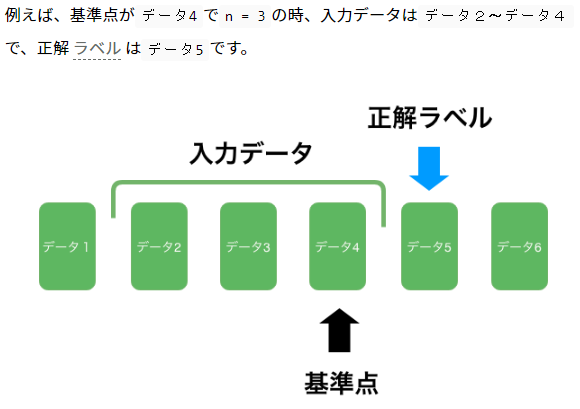

In [11]:
# trainとtestデータ
df_train_scale.head(3)
df_test_scale.head(3)

,0
0,0.070189
1,0.059937
2,0.044953


In [12]:
# LSTn用の入力データ・正解ラベルの作成　独自関数を作成。
#　引数に look_back,dataset
import numpy as np

def create_dataset(dataset, look_back):
    data_X, data_Y = [], []
    for i in range(look_back, len(dataset)):
        data_X.append(dataset[i-look_back:i, 0])
        data_Y.append(dataset[i, 0])
    return np.array(data_X), np.array(data_Y)

In [13]:
# その独自関数の呼び出し
look_back = 5

train_X, train_Y = create_dataset(train, look_back)
test_X, test_Y = create_dataset(test, look_back)

train_X_df = pd.DataFrame(train_X)
train_X_df

,0,1,2,3,4
0,0.853312,0.880915,0.891167,0.891167,0.860410
1,0.880915,0.891167,0.891167,0.860410,0.842271
2,0.891167,0.891167,0.860410,0.842271,0.848580
3,0.891167,0.860410,0.842271,0.848580,0.867508
4,0.860410,0.842271,0.848580,0.867508,0.862776
...,...,...,...,...,...
1372,0.026814,0.026025,0.044953,0.040221,0.047319
1373,0.026025,0.044953,0.040221,0.047319,0.050473
1374,0.044953,0.040221,0.047319,0.050473,0.049487
1375,0.040221,0.047319,0.050473,0.049487,0.041798


look backが5つなんで、5列あるという訳ですね。

そして時系列なので斜めが同じ数値になっている。⇒一つづつズレている。という事に着目。

In [14]:
# データの確認
print('train_X')
print(train_X)
print()
print('train_Y')
print(train_Y)
print()
print('test_X')
print(test_X)
print()
print('test_Y')
print(test_Y)

train_X
[[0.85331225 0.8809148  0.89116716 0.89116716 0.8604101 ]
 [0.8809148  0.89116716 0.89116716 0.8604101  0.8422713 ]
 [0.89116716 0.89116716 0.8604101  0.8422713  0.8485805 ]
 ...
 [0.04495269 0.0402208  0.04731864 0.05047321 0.04948741]
 [0.0402208  0.04731864 0.05047321 0.04948741 0.04179811]
 [0.04731864 0.05047321 0.04948741 0.04179811 0.05441642]]

train_Y
[0.8422713  0.8485805  0.8675078  ... 0.04179811 0.05441642 0.06309146]

test_X
[[ 0.0701893   0.05993688  0.04495269  0.04810727  0.05362779]
 [ 0.05993688  0.04495269  0.04810727  0.05362779  0.04100949]
 [ 0.04495269  0.04810727  0.05362779  0.04100949  0.0402208 ]
 ...
 [-0.05126184 -0.08438486 -0.06072557 -0.08832806 -0.08753943]
 [-0.08438486 -0.06072557 -0.08832806 -0.08753943 -0.07807571]
 [-0.06072557 -0.08832806 -0.08753943 -0.07807571 -0.05914825]]

test_Y
[ 0.04100949  0.0402208   0.04968452  0.04652995  0.05835962  0.04810727
  0.05047321  0.04574132  0.04810727  0.0498817   0.03391165  0.02917981
  0.0173501

### [データ整形](https://premium.aidemy.jp/courses/6160/exercises/3xXX8qwu7-)
作成したデータはLSTMで分析できるデータ形式ではない⇒入力データの整形。

入力データを<font color="red">行数×変数数×カラム数</font>の3次元の行列に変換、LSTMで分析できるデータ形式に整形する。

- 行数：データの総数 　　　　　　　　　　　　　入力データの総数61
- 変数数：1セットのデータに含まれる要素数　　１セットの入力データに含まれる要素数look_backで指定した3
- カラム数：扱うデータの種別数　　　　　　　　売上データのみを扱うので1

reshapeメソッドを用いて、データを指定した形式の行列に変換します。

In [15]:
# 3次元のnumpy.ndarrayに変換します⇒ reshapeでLSTN用に変換している。
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

### [LSTMネットワークの構築と訓練](https://premium.aidemy.jp/courses/6160/exercises/mRBWTDAXqs)

、LSTMネットワークを構築し、これまでに用意したデータを用いてモデルの訓練（学習）と予測、評価

忘備録として、私の進捗を残しましたが、4回目のみ実装して頂ければ平気かと。

#### 1回目の学習

6行目のレイヤーはモデルの最初のレイヤーのため、引数input_shapeを指定します。以降の層では、引数input_shapeは指定しない。

出力層：モデル最後のレイヤー：出力結果を吐き出す物。
1つのノードを持つ全結合層を追加します。

訓練過程における損失関数（loss）と最適化アルゴリズム（optimizer）の定義

正解ラベルと出力の誤差がより小さくなるように。⇒損失関数の値が小さいほど予測が正確。

分類：categorical_crossentropy

回帰：mean_squared_error

最適化アルゴリズムとは、損失関数の値を減少させるように、重みを更新するアルゴリズム。

どれが有効化は分からないので、毎度確認していく。

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# LSTMモデルの作成｡
model = keras.Sequential()                                                      
model.add(layers.LSTM(8, input_shape=(look_back, 1))) # 8つのLSTMブロックからなるレイヤー(層)を追加。
model.add(layers.Dense(1))                                                   # 出力層だから今回は１固定。

model.compile(loss='mean_squared_error', optimizer='adam')


# LSTMネットワークの訓練（学習）
model.fit(train_X, train_Y, epochs=20, batch_size=1, verbose=2)

history = model.fit(train_X, train_Y, epochs=20, batch_size=1, verbose=2)

#loss: loss: 8.5483e-04 

Epoch 1/20
1377/1377 - 8s - loss: 0.0269 - 8s/epoch - 6ms/step
Epoch 2/20
1377/1377 - 4s - loss: 8.7941e-04 - 4s/epoch - 3ms/step
Epoch 3/20
1377/1377 - 5s - loss: 8.9369e-04 - 5s/epoch - 3ms/step
Epoch 4/20
1377/1377 - 3s - loss: 8.1830e-04 - 3s/epoch - 2ms/step
Epoch 5/20
1377/1377 - 3s - loss: 7.7729e-04 - 3s/epoch - 2ms/step
Epoch 6/20
1377/1377 - 3s - loss: 7.1320e-04 - 3s/epoch - 2ms/step
Epoch 7/20
1377/1377 - 3s - loss: 6.5403e-04 - 3s/epoch - 2ms/step
Epoch 8/20
1377/1377 - 3s - loss: 6.1782e-04 - 3s/epoch - 2ms/step
Epoch 9/20
1377/1377 - 3s - loss: 5.7806e-04 - 3s/epoch - 2ms/step
Epoch 10/20
1377/1377 - 3s - loss: 5.4898e-04 - 3s/epoch - 2ms/step
Epoch 11/20
1377/1377 - 3s - loss: 4.8279e-04 - 3s/epoch - 2ms/step
Epoch 12/20
1377/1377 - 3s - loss: 4.1269e-04 - 3s/epoch - 2ms/step
Epoch 13/20
1377/1377 - 3s - loss: 3.9308e-04 - 3s/epoch - 2ms/step
Epoch 14/20
1377/1377 - 3s - loss: 4.0327e-04 - 3s/epoch - 2ms/step
Epoch 15/20
1377/1377 - 3s - loss: 4.0471e-04 - 3s/epoch - 2m

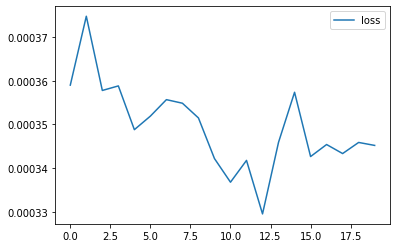

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# 学習過程のプロット
plt.plot(history.epoch, history.history["loss"], label="loss")
plt.legend()

#### 1回目を考慮した2回目の学習

これはAidemyの教材通り

64,32という数字はどこから来たのか？何を持って決めたのか？⇒
2の乗数で決まる。

batch_sizeも何をもって決めたのか？

return_sequences=True ⇒LSTNの時系列データで使用する際に引数として使用する。

最後の出力層で model.add(layers.Dense(1)) になるじゃないですか。

それと<font color="red">**くっつくレイヤーにはreturn_sequences=Trueは不要**</font>です。

In [18]:
# LSTMモデルの作成
model2 = keras.Sequential()

model2.add(layers.LSTM(64, input_shape=(look_back, 1), return_sequences=True))
model2.add(layers.LSTM(32,return_sequences=True))

model2.add(layers.LSTM(16,return_sequences=True)) #私が追加しました。
model2.add(layers.LSTM(8)) #私が追加しました。

model2.add(layers.Dense(1))
# モデルをコンパイルしてください
model2.compile(loss='mean_squared_error', optimizer='adam')
# 訓練を行ってください
# model.fit(train_X, train_Y, epochs=15, batch_size=1, verbose=2)

history2 = model2.fit(train_X, train_Y, epochs=15, batch_size=1, verbose=2)
# loss: 5.9269e-04

Epoch 1/15
1377/1377 - 15s - loss: 0.0063 - 15s/epoch - 11ms/step
Epoch 2/15
1377/1377 - 9s - loss: 0.0017 - 9s/epoch - 7ms/step
Epoch 3/15
1377/1377 - 9s - loss: 0.0015 - 9s/epoch - 7ms/step
Epoch 4/15
1377/1377 - 9s - loss: 0.0015 - 9s/epoch - 7ms/step
Epoch 5/15
1377/1377 - 9s - loss: 0.0013 - 9s/epoch - 7ms/step
Epoch 6/15
1377/1377 - 9s - loss: 0.0013 - 9s/epoch - 7ms/step
Epoch 7/15
1377/1377 - 9s - loss: 0.0013 - 9s/epoch - 7ms/step
Epoch 8/15
1377/1377 - 9s - loss: 0.0011 - 9s/epoch - 7ms/step
Epoch 9/15
1377/1377 - 10s - loss: 0.0011 - 10s/epoch - 7ms/step
Epoch 10/15
1377/1377 - 10s - loss: 0.0010 - 10s/epoch - 7ms/step
Epoch 11/15
1377/1377 - 10s - loss: 7.6424e-04 - 10s/epoch - 7ms/step
Epoch 12/15
1377/1377 - 9s - loss: 6.2076e-04 - 9s/epoch - 7ms/step
Epoch 13/15
1377/1377 - 9s - loss: 6.1408e-04 - 9s/epoch - 7ms/step
Epoch 14/15
1377/1377 - 10s - loss: 5.6047e-04 - 10s/epoch - 7ms/step
Epoch 15/15
1377/1377 - 10s - loss: 5.5316e-04 - 10s/epoch - 7ms/step


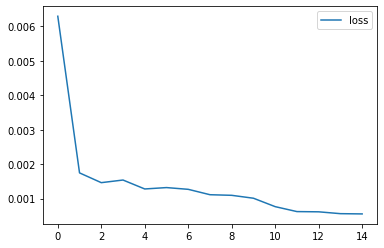

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# 学習過程のプロット
plt.plot(history2.epoch, history2.history["loss"], label="loss")
plt.legend()

#### 3回目の学習
Aidemyの教材通り

In [20]:
# LSTMモデルを作成してください
model3 = keras.Sequential()
model3.add(layers.LSTM(64, input_shape=(look_back, 1), return_sequences=True))
model3.add(layers.LSTM(32))
model3.add(layers.Dense(1))
# モデルをコンパイルしてください
model3.compile(loss='mean_squared_error', optimizer='adam')
# 訓練を行ってください
# model.fit(train_X, train_Y, epochs=15, batch_size=1, verbose=2)
# 学習
history3 = model3.fit(train_X, train_Y, epochs=15, batch_size=1, verbose=2)
# loss: 4.3211e-04 

Epoch 1/15
1377/1377 - 8s - loss: 0.0041 - 8s/epoch - 6ms/step
Epoch 2/15
1377/1377 - 6s - loss: 0.0012 - 6s/epoch - 4ms/step
Epoch 3/15
1377/1377 - 6s - loss: 0.0011 - 6s/epoch - 4ms/step
Epoch 4/15
1377/1377 - 5s - loss: 0.0010 - 5s/epoch - 4ms/step
Epoch 5/15
1377/1377 - 6s - loss: 9.4933e-04 - 6s/epoch - 4ms/step
Epoch 6/15
1377/1377 - 5s - loss: 7.3662e-04 - 5s/epoch - 4ms/step
Epoch 7/15
1377/1377 - 5s - loss: 6.2203e-04 - 5s/epoch - 4ms/step
Epoch 8/15
1377/1377 - 5s - loss: 5.6603e-04 - 5s/epoch - 4ms/step
Epoch 9/15
1377/1377 - 5s - loss: 5.6985e-04 - 5s/epoch - 4ms/step
Epoch 10/15
1377/1377 - 6s - loss: 5.1503e-04 - 6s/epoch - 4ms/step
Epoch 11/15
1377/1377 - 5s - loss: 5.4040e-04 - 5s/epoch - 4ms/step
Epoch 12/15
1377/1377 - 6s - loss: 4.9741e-04 - 6s/epoch - 4ms/step
Epoch 13/15
1377/1377 - 6s - loss: 4.7429e-04 - 6s/epoch - 4ms/step
Epoch 14/15
1377/1377 - 5s - loss: 4.7932e-04 - 5s/epoch - 4ms/step
Epoch 15/15
1377/1377 - 5s - loss: 4.8156e-04 - 5s/epoch - 4ms/step


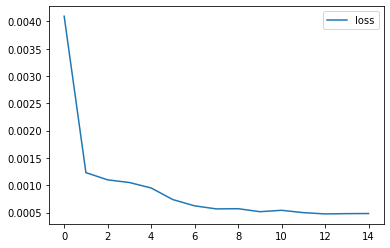

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
# 学習過程のプロット
plt.plot(history3.epoch, history3.history["loss"], label="loss")
plt.legend()

#### 4回目の学習
call backを用いたもの。

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# LSTMモデルの作成｡
model4 = keras.Sequential()                                                      
model4.add(layers.LSTM(8, input_shape=(look_back, 1))) # 8つのLSTMブロックからなるレイヤー(層)を追加。
model4.add(layers.Dense(1))                                                   # 出力層だから今回は１固定。

model4.compile(loss='mean_squared_error', optimizer='adam')

In [24]:
from keras import callbacks                   # コールバック（1epoch終了毎に呼び出される）
# モデルの学習
history4 = model4.fit(
    train_X,
    train_Y,
    batch_size=1,
    epochs=300, 
    validation_data=(test_X, test_Y),        # コールバックする際はvalidation dataも準備する。
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss',patience=30),
        callbacks.ModelCheckpoint(filepath = './model/best_model.h5',monitor='val_loss', save_best_only=True)
        ]
)
# val_lossが最も優れている学習結果を自動保存致します。

Epoch 1/300
1366/1377 [============================>.] - ETA: 0s - loss: 0.0050

1377/1377 [==============================] - 10s 5ms/step - loss: 0.0050 - val_loss: 3.2267e-04
Epoch 2/300
1361/1377 [============================>.] - ETA: 0s - loss: 6.8367e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 6.8162e-04 - val_loss: 3.1568e-04
Epoch 3/300
1367/1377 [============================>.] - ETA: 0s - loss: 6.7624e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 6.8231e-04 - val_loss: 3.0362e-04
Epoch 4/300
1377/1377 [==============================] - ETA: 0s - loss: 6.6180e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 6.6180e-04 - val_loss: 3.1730e-04
Epoch 5/300
1365/1377 [============================>.] - ETA: 0s - loss: 5.9772e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 5.9575e-04 - val_loss: 2.4325e-04
Epoch 6/300
1368/1377 [============================>.] - ETA: 0s - loss: 5.9868e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 5.9870e-04 - val_loss: 2.3528e-04
Epoch 7/300
1362/1377 [============================>.] - ETA: 0s - loss: 5.9810e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 6.0086e-04 - val_loss: 2.3414e-04
Epoch 8/300
1375/1377 [============================>.] - ETA: 0s - loss: 5.3544e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 5.3497e-04 - val_loss: 2.1296e-04
Epoch 9/300
1366/1377 [============================>.] - ETA: 0s - loss: 5.1670e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 5.1465e-04 - val_loss: 2.2334e-04
Epoch 10/300
1371/1377 [============================>.] - ETA: 0s - loss: 4.8415e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 4.8317e-04 - val_loss: 2.0501e-04
Epoch 11/300
1377/1377 [==============================] - ETA: 0s - loss: 4.5688e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 4.5688e-04 - val_loss: 2.6624e-04
Epoch 12/300
1361/1377 [============================>.] - ETA: 0s - loss: 4.4639e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 4.4540e-04 - val_loss: 1.8243e-04
Epoch 13/300
1361/1377 [============================>.] - ETA: 0s - loss: 4.0903e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 4.0551e-04 - val_loss: 1.7823e-04
Epoch 14/300
1358/1377 [============================>.] - ETA: 0s - loss: 4.0408e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 4.0169e-04 - val_loss: 1.6919e-04
Epoch 15/300
1374/1377 [============================>.] - ETA: 0s - loss: 3.7819e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.7783e-04 - val_loss: 1.5746e-04
Epoch 16/300
1361/1377 [============================>.] - ETA: 0s - loss: 3.8053e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.7956e-04 - val_loss: 1.6040e-04
Epoch 17/300
1359/1377 [============================>.] - ETA: 0s - loss: 3.5838e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.5922e-04 - val_loss: 2.2501e-04
Epoch 18/300
1376/1377 [============================>.] - ETA: 0s - loss: 3.6983e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 3.6959e-04 - val_loss: 1.4576e-04
Epoch 19/300
1374/1377 [============================>.] - ETA: 0s - loss: 3.7791e-04

1377/1377 [==============================] - 6s 5ms/step - loss: 3.7737e-04 - val_loss: 1.4183e-04
Epoch 20/300
1376/1377 [============================>.] - ETA: 0s - loss: 3.6407e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.6381e-04 - val_loss: 1.5944e-04
Epoch 21/300
1375/1377 [============================>.] - ETA: 0s - loss: 3.5563e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.5537e-04 - val_loss: 1.5824e-04
Epoch 22/300
1356/1377 [============================>.] - ETA: 0s - loss: 3.6557e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.6266e-04 - val_loss: 1.6622e-04
Epoch 23/300
1362/1377 [============================>.] - ETA: 0s - loss: 3.7088e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.6814e-04 - val_loss: 1.3914e-04
Epoch 24/300
1372/1377 [============================>.] - ETA: 0s - loss: 3.6823e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.7235e-04 - val_loss: 1.4505e-04
Epoch 25/300
1363/1377 [============================>.] - ETA: 0s - loss: 3.6026e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.6026e-04 - val_loss: 1.4367e-04
Epoch 26/300
1360/1377 [============================>.] - ETA: 0s - loss: 3.5997e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.5908e-04 - val_loss: 2.1794e-04
Epoch 27/300
1376/1377 [============================>.] - ETA: 0s - loss: 3.4497e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.4481e-04 - val_loss: 1.3481e-04
Epoch 28/300
1361/1377 [============================>.] - ETA: 0s - loss: 3.7193e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 3.6906e-04 - val_loss: 1.8044e-04
Epoch 29/300
1360/1377 [============================>.] - ETA: 0s - loss: 3.5663e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.5908e-04 - val_loss: 1.9057e-04
Epoch 30/300
1369/1377 [============================>.] - ETA: 0s - loss: 3.4642e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4559e-04 - val_loss: 2.0366e-04
Epoch 31/300
1367/1377 [============================>.] - ETA: 0s - loss: 3.5359e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.5460e-04 - val_loss: 1.7365e-04
Epoch 32/300
1367/1377 [============================>.] - ETA: 0s - loss: 3.5005e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.4936e-04 - val_loss: 1.3450e-04
Epoch 33/300
1359/1377 [============================>.] - ETA: 0s - loss: 3.4877e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 3.4844e-04 - val_loss: 1.3449e-04
Epoch 34/300
1365/1377 [============================>.] - ETA: 0s - loss: 3.5805e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.5780e-04 - val_loss: 2.0605e-04
Epoch 35/300
1370/1377 [============================>.] - ETA: 0s - loss: 3.5634e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.5534e-04 - val_loss: 1.3925e-04
Epoch 36/300
1371/1377 [============================>.] - ETA: 0s - loss: 3.4785e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 3.4746e-04 - val_loss: 2.2240e-04
Epoch 37/300
1358/1377 [============================>.] - ETA: 0s - loss: 3.4245e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.4323e-04 - val_loss: 1.3355e-04
Epoch 38/300
1363/1377 [============================>.] - ETA: 0s - loss: 3.5255e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.5291e-04 - val_loss: 1.6735e-04
Epoch 39/300
1370/1377 [============================>.] - ETA: 0s - loss: 3.4295e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4173e-04 - val_loss: 1.5572e-04
Epoch 40/300
1373/1377 [============================>.] - ETA: 0s - loss: 3.4218e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4216e-04 - val_loss: 1.3050e-04
Epoch 41/300
1369/1377 [============================>.] - ETA: 0s - loss: 3.4684e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.4527e-04 - val_loss: 1.3136e-04
Epoch 42/300
1357/1377 [============================>.] - ETA: 0s - loss: 3.5553e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.5208e-04 - val_loss: 2.2255e-04
Epoch 43/300
1374/1377 [============================>.] - ETA: 0s - loss: 3.4572e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4553e-04 - val_loss: 1.5508e-04
Epoch 44/300
1366/1377 [============================>.] - ETA: 0s - loss: 3.5053e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.5060e-04 - val_loss: 1.3015e-04
Epoch 45/300
1375/1377 [============================>.] - ETA: 0s - loss: 3.5565e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.5551e-04 - val_loss: 1.4501e-04
Epoch 46/300
1373/1377 [============================>.] - ETA: 0s - loss: 3.3727e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 3.3671e-04 - val_loss: 1.3070e-04
Epoch 47/300
1370/1377 [============================>.] - ETA: 0s - loss: 3.4671e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4575e-04 - val_loss: 1.3743e-04
Epoch 48/300
1369/1377 [============================>.] - ETA: 0s - loss: 3.3530e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3414e-04 - val_loss: 1.4019e-04
Epoch 49/300
1362/1377 [============================>.] - ETA: 0s - loss: 3.2680e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2572e-04 - val_loss: 1.4108e-04
Epoch 50/300
1371/1377 [============================>.] - ETA: 0s - loss: 3.4783e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4699e-04 - val_loss: 2.0388e-04
Epoch 51/300
1361/1377 [============================>.] - ETA: 0s - loss: 3.2446e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3426e-04 - val_loss: 1.9232e-04
Epoch 52/300
1376/1377 [============================>.] - ETA: 0s - loss: 3.4056e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.4037e-04 - val_loss: 2.5107e-04
Epoch 53/300
1362/1377 [============================>.] - ETA: 0s - loss: 3.4231e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4075e-04 - val_loss: 1.3249e-04
Epoch 54/300
1360/1377 [============================>.] - ETA: 0s - loss: 3.4589e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4319e-04 - val_loss: 1.4303e-04
Epoch 55/300
1356/1377 [============================>.] - ETA: 0s - loss: 3.2707e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3289e-04 - val_loss: 1.2774e-04
Epoch 56/300
1365/1377 [============================>.] - ETA: 0s - loss: 3.3376e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3607e-04 - val_loss: 1.4145e-04
Epoch 57/300
1359/1377 [============================>.] - ETA: 0s - loss: 3.5062e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4796e-04 - val_loss: 1.3911e-04
Epoch 58/300
1375/1377 [============================>.] - ETA: 0s - loss: 3.3914e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3891e-04 - val_loss: 1.6881e-04
Epoch 59/300
1367/1377 [============================>.] - ETA: 0s - loss: 3.3226e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3147e-04 - val_loss: 1.4031e-04
Epoch 60/300
1364/1377 [============================>.] - ETA: 0s - loss: 3.4862e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4724e-04 - val_loss: 1.4140e-04
Epoch 61/300
1376/1377 [============================>.] - ETA: 0s - loss: 3.3371e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3392e-04 - val_loss: 1.6746e-04
Epoch 62/300
1369/1377 [============================>.] - ETA: 0s - loss: 3.3510e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 3.3519e-04 - val_loss: 1.2555e-04
Epoch 63/300
1362/1377 [============================>.] - ETA: 0s - loss: 3.3702e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3411e-04 - val_loss: 1.3539e-04
Epoch 64/300
1366/1377 [============================>.] - ETA: 0s - loss: 3.4084e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4086e-04 - val_loss: 1.3904e-04
Epoch 65/300
1358/1377 [============================>.] - ETA: 0s - loss: 3.2885e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3027e-04 - val_loss: 1.2885e-04
Epoch 66/300
1364/1377 [============================>.] - ETA: 0s - loss: 3.4140e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4109e-04 - val_loss: 1.8165e-04
Epoch 67/300
1372/1377 [============================>.] - ETA: 0s - loss: 3.3350e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3277e-04 - val_loss: 2.1749e-04
Epoch 68/300
1368/1377 [============================>.] - ETA: 0s - loss: 3.4460e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4375e-04 - val_loss: 1.2588e-04
Epoch 69/300
1374/1377 [============================>.] - ETA: 0s - loss: 3.3815e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3776e-04 - val_loss: 1.7238e-04
Epoch 70/300
1356/1377 [============================>.] - ETA: 0s - loss: 3.3885e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3657e-04 - val_loss: 1.2906e-04
Epoch 71/300
1362/1377 [============================>.] - ETA: 0s - loss: 3.3869e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3881e-04 - val_loss: 1.8124e-04
Epoch 72/300
1377/1377 [==============================] - ETA: 0s - loss: 3.2678e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2678e-04 - val_loss: 1.3409e-04
Epoch 73/300
1367/1377 [============================>.] - ETA: 0s - loss: 3.2024e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2195e-04 - val_loss: 1.3256e-04
Epoch 74/300
1367/1377 [============================>.] - ETA: 0s - loss: 3.3979e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 3.3908e-04 - val_loss: 1.7281e-04
Epoch 75/300
1359/1377 [============================>.] - ETA: 0s - loss: 3.2766e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3130e-04 - val_loss: 1.2880e-04
Epoch 76/300
1377/1377 [==============================] - ETA: 0s - loss: 3.3205e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3205e-04 - val_loss: 1.2351e-04
Epoch 77/300
1371/1377 [============================>.] - ETA: 0s - loss: 3.4864e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4774e-04 - val_loss: 1.4560e-04
Epoch 78/300
1356/1377 [============================>.] - ETA: 0s - loss: 3.4345e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4395e-04 - val_loss: 2.3560e-04
Epoch 79/300
1356/1377 [============================>.] - ETA: 0s - loss: 3.3174e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3068e-04 - val_loss: 1.7671e-04
Epoch 80/300
1364/1377 [============================>.] - ETA: 0s - loss: 3.3164e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3262e-04 - val_loss: 1.3087e-04
Epoch 81/300
1369/1377 [============================>.] - ETA: 0s - loss: 3.3472e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3552e-04 - val_loss: 2.3685e-04
Epoch 82/300
1362/1377 [============================>.] - ETA: 0s - loss: 3.2645e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3359e-04 - val_loss: 1.2254e-04
Epoch 83/300
1365/1377 [============================>.] - ETA: 0s - loss: 3.2354e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2279e-04 - val_loss: 1.2510e-04
Epoch 84/300
1369/1377 [============================>.] - ETA: 0s - loss: 3.2711e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3084e-04 - val_loss: 1.7616e-04
Epoch 85/300
1373/1377 [============================>.] - ETA: 0s - loss: 3.2632e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2607e-04 - val_loss: 1.7207e-04
Epoch 86/300
1357/1377 [============================>.] - ETA: 0s - loss: 3.3756e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3512e-04 - val_loss: 1.2250e-04
Epoch 87/300
1365/1377 [============================>.] - ETA: 0s - loss: 3.3442e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3478e-04 - val_loss: 1.2956e-04
Epoch 88/300
1371/1377 [============================>.] - ETA: 0s - loss: 3.3062e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3082e-04 - val_loss: 1.4194e-04
Epoch 89/300
1373/1377 [============================>.] - ETA: 0s - loss: 3.3688e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3763e-04 - val_loss: 1.7465e-04
Epoch 90/300
1356/1377 [============================>.] - ETA: 0s - loss: 3.3287e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3070e-04 - val_loss: 1.3385e-04
Epoch 91/300
1374/1377 [============================>.] - ETA: 0s - loss: 3.3740e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 3.3669e-04 - val_loss: 1.3543e-04
Epoch 92/300
1356/1377 [============================>.] - ETA: 0s - loss: 3.4025e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3790e-04 - val_loss: 1.2940e-04
Epoch 93/300
1372/1377 [============================>.] - ETA: 0s - loss: 3.4323e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4220e-04 - val_loss: 1.2239e-04
Epoch 94/300
1361/1377 [============================>.] - ETA: 0s - loss: 3.2611e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2387e-04 - val_loss: 1.3065e-04
Epoch 95/300
1371/1377 [============================>.] - ETA: 0s - loss: 3.2274e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2240e-04 - val_loss: 1.3954e-04
Epoch 96/300
1372/1377 [============================>.] - ETA: 0s - loss: 3.2281e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2262e-04 - val_loss: 1.2119e-04
Epoch 97/300
1367/1377 [============================>.] - ETA: 0s - loss: 3.2961e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2862e-04 - val_loss: 1.2921e-04
Epoch 98/300
1366/1377 [============================>.] - ETA: 0s - loss: 3.2948e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2937e-04 - val_loss: 1.6635e-04
Epoch 99/300
1371/1377 [============================>.] - ETA: 0s - loss: 3.2289e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2231e-04 - val_loss: 1.2356e-04
Epoch 100/300
1367/1377 [============================>.] - ETA: 0s - loss: 3.3017e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 3.3127e-04 - val_loss: 1.2055e-04
Epoch 101/300
1371/1377 [============================>.] - ETA: 0s - loss: 3.3108e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3004e-04 - val_loss: 1.2154e-04
Epoch 102/300
1365/1377 [============================>.] - ETA: 0s - loss: 3.3110e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2946e-04 - val_loss: 1.9435e-04
Epoch 103/300
1366/1377 [============================>.] - ETA: 0s - loss: 3.2653e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2551e-04 - val_loss: 1.3367e-04
Epoch 104/300
1373/1377 [============================>.] - ETA: 0s - loss: 3.2870e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2824e-04 - val_loss: 2.4246e-04
Epoch 105/300
1372/1377 [============================>.] - ETA: 0s - loss: 3.3495e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3424e-04 - val_loss: 1.1852e-04
Epoch 106/300
1375/1377 [============================>.] - ETA: 0s - loss: 3.2557e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2520e-04 - val_loss: 1.2592e-04
Epoch 107/300
1359/1377 [============================>.] - ETA: 0s - loss: 3.3219e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2882e-04 - val_loss: 1.4452e-04
Epoch 108/300
1376/1377 [============================>.] - ETA: 0s - loss: 3.2907e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2910e-04 - val_loss: 1.3443e-04
Epoch 109/300
1370/1377 [============================>.] - ETA: 0s - loss: 3.2747e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2777e-04 - val_loss: 1.7571e-04
Epoch 110/300
1364/1377 [============================>.] - ETA: 0s - loss: 3.2592e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2678e-04 - val_loss: 1.2205e-04
Epoch 111/300
1363/1377 [============================>.] - ETA: 0s - loss: 3.2752e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2485e-04 - val_loss: 1.2799e-04
Epoch 112/300
1373/1377 [============================>.] - ETA: 0s - loss: 3.2611e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2724e-04 - val_loss: 1.1846e-04
Epoch 113/300
1360/1377 [============================>.] - ETA: 0s - loss: 3.3660e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3529e-04 - val_loss: 1.2239e-04
Epoch 114/300
1362/1377 [============================>.] - ETA: 0s - loss: 3.1579e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.1823e-04 - val_loss: 1.4747e-04
Epoch 115/300
1377/1377 [==============================] - ETA: 0s - loss: 3.3178e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3178e-04 - val_loss: 1.4247e-04
Epoch 116/300
1376/1377 [============================>.] - ETA: 0s - loss: 3.1890e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.1878e-04 - val_loss: 1.1813e-04
Epoch 117/300
1363/1377 [============================>.] - ETA: 0s - loss: 3.2214e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2954e-04 - val_loss: 1.1915e-04
Epoch 118/300
1359/1377 [============================>.] - ETA: 0s - loss: 3.3533e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3601e-04 - val_loss: 1.2424e-04
Epoch 119/300
1367/1377 [============================>.] - ETA: 0s - loss: 3.4867e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.4783e-04 - val_loss: 1.5619e-04
Epoch 120/300
1372/1377 [============================>.] - ETA: 0s - loss: 3.2779e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2701e-04 - val_loss: 1.1885e-04
Epoch 121/300
1356/1377 [============================>.] - ETA: 0s - loss: 3.2351e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2510e-04 - val_loss: 1.2070e-04
Epoch 122/300
1372/1377 [============================>.] - ETA: 0s - loss: 3.1959e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2046e-04 - val_loss: 1.2533e-04
Epoch 123/300
1360/1377 [============================>.] - ETA: 0s - loss: 3.1998e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.1921e-04 - val_loss: 1.2375e-04
Epoch 124/300
1363/1377 [============================>.] - ETA: 0s - loss: 3.2935e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2957e-04 - val_loss: 1.2012e-04
Epoch 125/300
1367/1377 [============================>.] - ETA: 0s - loss: 3.2860e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2659e-04 - val_loss: 1.9064e-04
Epoch 126/300
1375/1377 [============================>.] - ETA: 0s - loss: 3.2802e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2788e-04 - val_loss: 1.2093e-04
Epoch 127/300
1364/1377 [============================>.] - ETA: 0s - loss: 3.2517e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2382e-04 - val_loss: 1.2322e-04
Epoch 128/300
1362/1377 [============================>.] - ETA: 0s - loss: 3.2475e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2342e-04 - val_loss: 1.7573e-04
Epoch 129/300
1374/1377 [============================>.] - ETA: 0s - loss: 3.1805e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.1815e-04 - val_loss: 1.3543e-04
Epoch 130/300
1362/1377 [============================>.] - ETA: 0s - loss: 3.3460e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3429e-04 - val_loss: 1.9314e-04
Epoch 131/300
1363/1377 [============================>.] - ETA: 0s - loss: 3.3021e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2784e-04 - val_loss: 1.2347e-04
Epoch 132/300
1376/1377 [============================>.] - ETA: 0s - loss: 3.2704e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2708e-04 - val_loss: 1.8684e-04
Epoch 133/300
1374/1377 [============================>.] - ETA: 0s - loss: 3.2627e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2592e-04 - val_loss: 1.2615e-04
Epoch 134/300
1364/1377 [============================>.] - ETA: 0s - loss: 3.3432e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3278e-04 - val_loss: 2.0035e-04
Epoch 135/300
1368/1377 [============================>.] - ETA: 0s - loss: 3.2795e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2695e-04 - val_loss: 1.1917e-04
Epoch 136/300
1358/1377 [============================>.] - ETA: 0s - loss: 3.3845e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.3954e-04 - val_loss: 1.1935e-04
Epoch 137/300
1368/1377 [============================>.] - ETA: 0s - loss: 3.3241e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.3074e-04 - val_loss: 1.2066e-04
Epoch 138/300
1360/1377 [============================>.] - ETA: 0s - loss: 3.2498e-04

1377/1377 [==============================] - 4s 3ms/step - loss: 3.2641e-04 - val_loss: 1.2345e-04
Epoch 139/300
1362/1377 [============================>.] - ETA: 0s - loss: 3.2605e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2355e-04 - val_loss: 1.2334e-04
Epoch 140/300
1377/1377 [==============================] - ETA: 0s - loss: 3.2673e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2673e-04 - val_loss: 1.2497e-04
Epoch 141/300
1376/1377 [============================>.] - ETA: 0s - loss: 3.2841e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 3.2827e-04 - val_loss: 1.4930e-04
Epoch 142/300
1372/1377 [============================>.] - ETA: 0s - loss: 3.2289e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2195e-04 - val_loss: 1.2879e-04
Epoch 143/300
1358/1377 [============================>.] - ETA: 0s - loss: 3.2855e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2942e-04 - val_loss: 1.2029e-04
Epoch 144/300
1362/1377 [============================>.] - ETA: 0s - loss: 3.3512e-04

1377/1377 [==============================] - 5s 4ms/step - loss: 3.3418e-04 - val_loss: 1.2005e-04
Epoch 145/300
1363/1377 [============================>.] - ETA: 0s - loss: 3.1999e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2039e-04 - val_loss: 1.5860e-04
Epoch 146/300
1371/1377 [============================>.] - ETA: 0s - loss: 3.2262e-04

1377/1377 [==============================] - 5s 3ms/step - loss: 3.2279e-04 - val_loss: 1.6200e-04


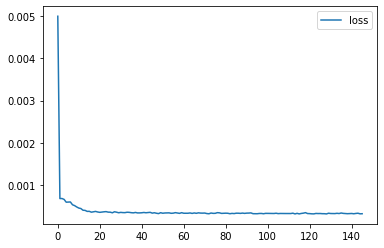

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
# 学習過程のプロット
plt.plot(history4.epoch, history4.history["loss"], label="loss")
plt.legend()

In [26]:
# history = model.fit(train_X, train_Y, epochs=15, batch_size=1, verbose=2)
# loss: 4.3211e-04 
train_X
train_Y
train_Y = train_Y.reshape(-1,1)
train_Y

array([[0.8422713 ],
       [0.8485805 ],
       [0.8675078 ],
       ...,
       [0.04179811],
       [0.05441642],
       [0.06309146]], dtype=float32)

### [データの予測と評価](https://premium.aidemy.jp/courses/6160/exercises/ZNnpEhme53)

#### 正規化を元に戻す
予測したデータや結果を正しく評価、可視化する為の処理ですね。

4回目の学習がhistory4

In [27]:
#予測データの作成
train_predict =model.predict(train_X)
test_predict = model.predict(test_X) 

train_predict2 =model2.predict(train_X)
test_predict2 = model2.predict(test_X) 

train_predict3 =model3.predict(train_X)
test_predict3 = model3.predict(test_X) 

train_predict4 =model4.predict(train_X)
test_predict4 = model4.predict(test_X) 


予測データを作成しました。その予測データを正しく評価するには<font color="red">スケーリングしたデータを元に戻す</font>必要があります。

元に戻すには<font color="red">inverse_transform()メソッド</font>

**正規化したらもとに戻す**という手順が必要。

test_Yの整形 ⇒ ちゃんと比較対象を統一させましょう。677行1列なのか、1列677行なのか。

rmseで使用

In [28]:
# ちゃんと677行１列にする。

test_Y.shape
test_Y = test_Y.reshape(-1,1)
test_Y.shape
test_Y

test_Y = scaler_train.inverse_transform(test_Y)
test_Y

array([[ 8680.    ],
       [ 8670.    ],
       [ 8790.    ],
       [ 8750.    ],
       [ 8900.    ],
       [ 8770.    ],
       [ 8800.    ],
       [ 8740.    ],
       [ 8770.    ],
       [ 8792.5   ],
       [ 8590.    ],
       [ 8530.    ],
       [ 8380.    ],
       [ 8450.    ],
       [ 8530.    ],
       [ 8700.    ],
       [ 8710.    ],
       [ 8640.    ],
       [ 8580.    ],
       [ 8290.    ],
       [ 8445.5   ],
       [ 8490.    ],
       [ 8680.    ],
       [ 8650.    ],
       [ 8687.5   ],
       [ 8790.    ],
       [ 8600.    ],
       [ 8460.    ],
       [ 8570.    ],
       [ 8480.    ],
       [ 8650.    ],
       [ 8730.    ],
       [ 8780.    ],
       [ 8610.    ],
       [ 8770.    ],
       [ 8940.    ],
       [ 9060.    ],
       [ 8960.    ],
       [ 8950.    ],
       [ 8870.    ],
       [ 8790.    ],
       [ 8780.    ],
       [ 8660.    ],
       [ 8740.    ],
       [ 8620.    ],
       [ 8710.    ],
       [ 8940.    ],
       [ 9040

算出した予測値の整形

In [29]:
test_predict
test_predict.shape

(677, 1)

In [30]:
test_predict  = scaler_train.inverse_transform(test_predict)
test_predict2 = scaler_train.inverse_transform(test_predict2)
test_predict3 = scaler_train.inverse_transform(test_predict3)
test_predict4 = scaler_train.inverse_transform(test_predict4)

あまり

#### rmseの算出
ちゃんと双方のデータ形式をそろえる事。

まずはrmse比較する２つのデータの形状を確認して必要ならばそろえる。

その必要があったので揃えます。

In [31]:
# まずはrmse比較する２つのデータの形状を確認して必要ならばそろえる。
test_predict.shape

# test_Y      # これがおかしい。1列29行になってる。　ちゃんと29行1列にしないと。

(677, 1)

In [32]:
# これで変換
import numpy as np
# test_Y = test_Y.reshape(29,1)

# 返還後は確認しましょう。
print(test_predict.shape)
print(test_predict2.shape)
print(test_predict3.shape)
print(test_predict4.shape)
print(test_Y.shape)

(677, 1)
(677, 1)
(677, 1)
(677, 1)
(677, 1)


In [33]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
# y_trainと予測値のRMSEを出す

print("No1のRMSE",np.sqrt(MSE(test_predict,test_Y)))
print("No2のRMSE",np.sqrt(MSE(test_predict2,test_Y)))
print("No3のRMSE",np.sqrt(MSE(test_predict3,test_Y)))
print("No4のRMSE",np.sqrt(MSE(test_predict4,test_Y)))

No1のRMSE 145.98297
No2のRMSE 189.88597
No3のRMSE 144.85132
No4のRMSE 161.38802


#### [データ可視化](https://premium.aidemy.jp/courses/6160/exercises/9ShLDO1Ukc)
可視化する時もデータを整形する事。

こちら私が可視化したもの。

プロット時にこのようにデータ出力範囲を限定させました。

```
plt.plot(df[1200:], label='dataset',color = "blue")
```

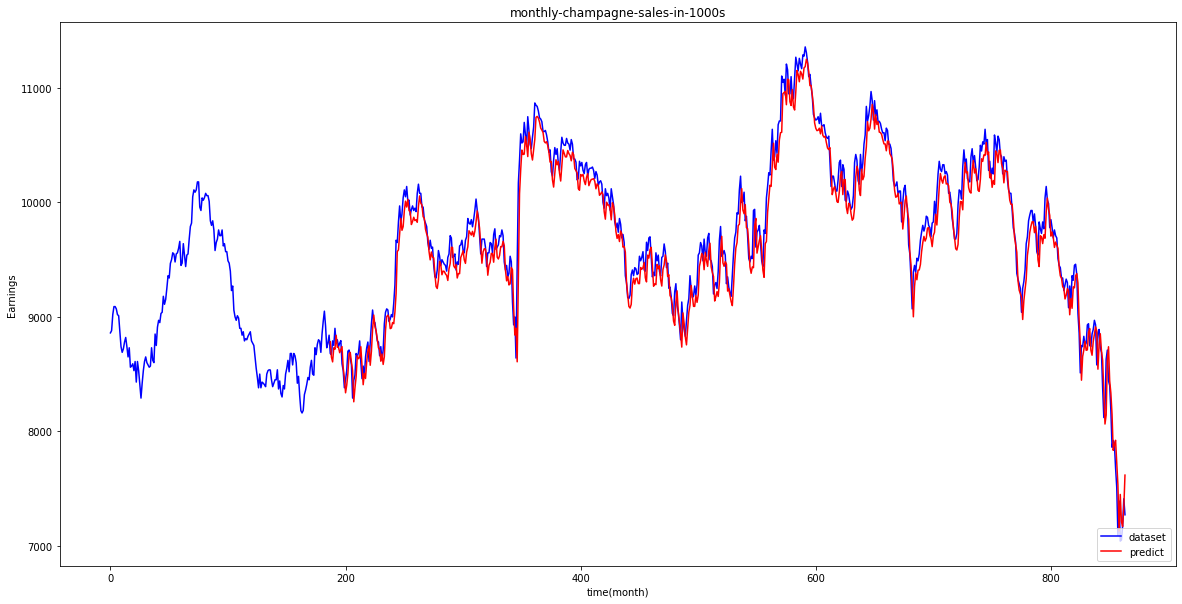

In [34]:
import matplotlib.pyplot as plt
plt.rc("figure",figsize=(20,10))
# 検証データから予測したデータの整形
# 既存の配列`dataset`と同じ大きさ（行数・列数）、データ型で
# 値を０に初期化したプロット用の空の配列を作成します
test_predict_plot = np.empty_like(df)

# 空の配列のすべての値を欠損値`nan`にします
test_predict_plot[:, :] = np.nan

# 訓練データの予測値と位置を合わせます
test_predict_plot[len(train_predict)+(look_back*2):len(df), :] = test_predict4

# データのプロット
plt.title("monthly-champagne-sales-in-1000s")
plt.xlabel("time(month)")
plt.ylabel("Earnings")

# 読み込んだままのデータをプロットします
# plt.plot(df, label='dataset',color = "blue")
plt.plot(df[1200:], label='dataset',color = "blue")

# 検証データから予測した値をプロットします
plt.plot(test_predict_plot[1200:], label='predict',color = "red")

plt.legend(loc='lower right') # 右下に表示しますと。





plt.show()

決して悪くないんじゃないですか？　

In [35]:
print(test_predict4.shape)
print(test_Y.shape)

(677, 1)
(677, 1)


In [36]:
test_Y
df

array([[18980.],
       [19330.],
       [19460.],
       ...,
       [ 7170.],
       [ 7410.],
       [ 7270.]], dtype=float32)